# Problem: Train an Autoencoder for Anomaly Detection

### Problem Statement
You are tasked with implementing an **autoencoder** model for anomaly detection. The model will be trained on the **MNIST dataset**, and anomalies will be detected based on the reconstruction error. The autoencoder consists of an encoder to compress the input and a decoder to reconstruct the image. The difference between the original image and the reconstructed image will be used to detect anomalies.

### Requirements
1. **Define the Autoencoder Architecture**:
   - **Encoder**:
     - Implement a series of convolutional layers followed by max-pooling layers.
     - The encoder should progressively reduce the spatial dimensions of the input image, capturing the most important features.
   - **Decoder**:
     - Implement a series of transposed convolutional layers (also known as deconvolutional layers) to upsample the compressed representation back to the original image size.
     - Use a **Sigmoid activation** function in the final layer to ensure that the output pixel values are between 0 and 1.

2. **Forward Pass**:
   - Implement the forward method where the input image is passed through the encoder to obtain a compressed representation, followed by passing it through the decoder to reconstruct the image.

### Constraints
- The autoencoder should work on the MNIST dataset, which consists of 28x28 grayscale images.
- Ensure that the output of the decoder matches the original image size.
- Use **Sigmoid activation** in the final layer to constrain the output pixel values between 0 and 1.

<details>
  <summary>💡 Hint</summary>
  Focus on the encoder to downsample the input and the decoder to upsample and reconstruct the image.
</details>

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
# for item in train_loader:
#     images, labels = item
#     print(f'Batch of images shape: {images.shape}')
#     print(f'Batch of labels shape: {labels.shape}')
#     break  # Just to show the shape of one batch
images[0].shape

torch.Size([1, 28, 28])

In [ ]:
# Define an Autoencoder model
# TODO: Implement the autoencoder architecture
class Autoencoder(nn.Module):
    def __init__(self):
        # init the parent class by delcaring super class
        super(Autoencoder, self).__init__()
        # # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3),  # b, 16, 28, 28 --> b, 16, 26, 26
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # b, 16, 26, 26 --> b, 16, 13, 13
            nn.Conv2d(16, 32, 3), # b, 16, 13, 13 --> b, 16, 11, 11
            nn.ReLU(),
            nn.MaxPool2d(2, 2)# b, 32, 11, 11 --> b, 32, 5, 5
        )
        # Decoder
        self.decoder = nn.Sequential(
            # 5x5 → 11x11
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0), # b, 32, 5, 5 → b, 16, 11, 11
            nn.ReLU(),            # 11x11 → 13x13
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=0), # b, 16, 11,11 → b, 16, 13, 13          
            nn.ReLU(),
            # 13x13 → 26x26
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # b, 16, 13, 13 → b, 1, 26, 26 
            nn.ReLU(),
            nn.ConvTranspose2d(1, 1, kernel_size=3, stride=1, padding=0),# b, 16, 26, 26 → b, 1, 28, 28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x= self.encoder(x)
        x= self.decoder(x)
        return x

# Initialize the model, loss function, and optimizer
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
    (7): Sigmoid()
  )
)

In [35]:
# Training loop
epochs = 10
for epoch in range(epochs):
    for images, _ in train_loader:
        # Forward pass
        # print(images.shape)
        reconstructed = model(images)
        loss = criterion(reconstructed, images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.9243
Epoch [2/10], Loss: 0.9278
Epoch [3/10], Loss: 0.9254
Epoch [4/10], Loss: 0.9283
Epoch [5/10], Loss: 0.9256
Epoch [6/10], Loss: 0.9305
Epoch [7/10], Loss: 0.9238
Epoch [8/10], Loss: 0.9299
Epoch [9/10], Loss: 0.9275
Epoch [10/10], Loss: 0.9241


In [36]:
# Detect anomalies using reconstruction error
threshold = 0.1  # Define a threshold for anomaly detection
model.eval()
anomalies = []
with torch.no_grad():
    for images, _ in test_loader:
        reconstructed = model(images)
        loss = criterion(reconstructed, images)
        
        # If reconstruction error exceeds the threshold, mark it as an anomaly
        if loss.item() > threshold:
            anomalies.append(images)

Anomaly image shape: torch.Size([28, 28])


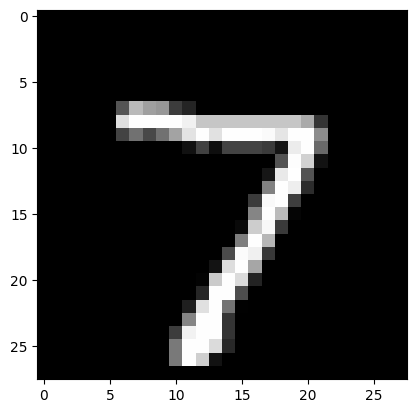

In [37]:
# Visualize anomalies
if anomalies:
    # Select the first anomaly and remove the channel dimension for visualization
    anomaly_image = anomalies[0][0].squeeze()  # Remove the channel dimension (1)
    print(f"Anomaly image shape: {anomaly_image.shape}")  # Optional: Check the shape of the image
    plt.imshow(anomaly_image.cpu().numpy(), cmap='gray')  # Convert tensor to NumPy array for visualization
    plt.show()
else:
    print("No anomalies detected.")
